In [1]:
#Notebook for Crime and Weather Data Wrangling
#ASSUMPTIONS
#We are only using 2016 date
#For weather we consider below fields:
  #Temperature
  #Pressure
  #Humidity
  #Wind
  #Precipitation
  #Clouds
#We are only focusing on top crime


#SEPARATE for crime count vs weather Carlos, Doris
#1. Agregate data based on crime count -> Larceny-from vehicle
#2. Agregate by date
#3. Get weather data per date
#4. Test correlations

#SEPARATE for crime count vs ice-cream shop Rabia, Isaiah 
#1. Agregate data based on crime count -> Larceny-from vehicle
#2. Agregate by date to get crime count ->5
#2. Add number of shops per coordinate per date -> take max count
#3. Correlate crime count vs number of shops

#VISUALIZATIONS & HYPOTHESIS TESTING FOR CRIME vs WEATHER
#location map of of count of crimes in Atlanta (put in the first part)
#pie chart of all types of crimes
#bar plot of LARCENY-FROM VEHICLE	 count per month in 2016
#ditplot of crime count
#distplot of max temps & each weather variable (pressure,humidity, wind, precipitation, cloud)
#scatter plot of crime count per date vs temperature
#scatter plot of crime count per date vs each weather variable (pressure,humidity, wind, precipitation, cloud)

#VISUALIZATIONS & HYPOTHESIS TESTING FOR CRIME vs ICE-CREAM
#distplot of ice-crem shop count
#scatter plot of crime count per date vs ice-cream shop count
#gplot of crime with max temp and ice-cream shop vcicnity (pick one row)

#CONCLUSION & OBSERVATIONS
#Result of testing hypothesis
#fun facts!

In [37]:
%matplotlib inline

#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import gmaps
import scipy.stats as sts
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

#Google developer API key {Carlos}
from config import gkey
#World Weather Online key- Trial 60 days {Carlos} https://www.worldweatheronline.com/developer/
from config import wokey


In [3]:
#Load Atlanta Crime Dataset taken from: https://data.world/bryantahb/crime-in-atlanta-2009-2017
path = os.path.join('..','Resources','atlcrime.csv')
df = pd.read_csv(path)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long
0,LARCENY-NON VEHICLE,103040029,10/31/2010,610 SPRING ST NW,509,Downtown,M,33.77101,-84.38895
1,AUTO THEFT,103040061,10/31/2010,850 OAK ST SW,401,West End,T,33.74057,-84.41680
2,LARCENY-FROM VEHICLE,103040169,10/31/2010,1344 METROPOLITAN PKWY SW,301,Capitol View Manor,X,33.71803,-84.40774
3,AUTO THEFT,103040174,10/31/2010,1752 PRYOR RD SW,307,Betmar LaVilla,Y,33.70731,-84.39674
4,LARCENY-NON VEHICLE,103040301,10/31/2010,JOHN WESLEY DOBBS AVE NE / CORLEY ST NE,604,Old Fourth Ward,M,33.75947,-84.36626


In [4]:
#Explore the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270688 entries, 0 to 270687
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   crime         270688 non-null  object 
 1   number        270688 non-null  int64  
 2   date          270688 non-null  object 
 3   location      270686 non-null  object 
 4   beat          270688 non-null  object 
 5   neighborhood  258928 non-null  object 
 6   npu           268592 non-null  object 
 7   lat           270688 non-null  float64
 8   long          270688 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 18.6+ MB


In [5]:
df.describe()

,number,lat,long
count,2.706880e+05,270688.000000,270688.000000
mean,4.705194e+08,33.755246,-84.408178
std,6.768886e+09,0.045540,0.047298
min,7.269234e+07,33.460100,-84.550500
25%,1.029113e+08,33.727780,-84.433880
50%,1.227606e+08,33.755380,-84.397520
75%,1.432412e+08,33.780140,-84.374090
max,1.704427e+11,33.886130,-84.286410


In [6]:
#Split Date column into day, month, and year to be able to call OpenWeather Statistics API
dsplit = df['date'].apply(lambda x: x.split("/"))
months = []
days = []
years = []

for item in dsplit:
    months.append(item[0])
    days.append(item[1])
    years.append(item[2])

#Create Month, Day and Year columns
df['Month'] = months
df['Day'] = days
df['Year'] = years

#Fix Data Types
df['Month']=df['Month'].astype(int)
df['Day']=df['Day'].astype(int)
df['Year']=df['Year'].astype(int)

df.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,LARCENY-NON VEHICLE,103040029,10/31/2010,610 SPRING ST NW,509,Downtown,M,33.77101,-84.38895,10,31,2010
1,AUTO THEFT,103040061,10/31/2010,850 OAK ST SW,401,West End,T,33.74057,-84.41680,10,31,2010
2,LARCENY-FROM VEHICLE,103040169,10/31/2010,1344 METROPOLITAN PKWY SW,301,Capitol View Manor,X,33.71803,-84.40774,10,31,2010
3,AUTO THEFT,103040174,10/31/2010,1752 PRYOR RD SW,307,Betmar LaVilla,Y,33.70731,-84.39674,10,31,2010
4,LARCENY-NON VEHICLE,103040301,10/31/2010,JOHN WESLEY DOBBS AVE NE / CORLEY ST NE,604,Old Fourth Ward,M,33.75947,-84.36626,10,31,2010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270688 entries, 0 to 270687
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   crime         270688 non-null  object 
 1   number        270688 non-null  int64  
 2   date          270688 non-null  object 
 3   location      270686 non-null  object 
 4   beat          270688 non-null  object 
 5   neighborhood  258928 non-null  object 
 6   npu           268592 non-null  object 
 7   lat           270688 non-null  float64
 8   long          270688 non-null  float64
 9   Month         270688 non-null  int64  
 10  Day           270688 non-null  int64  
 11  Year          270688 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 24.8+ MB


In [8]:
#We will only focus on crime happenning in year 2016
crime = df.loc[df['Year']==2016]
crime.reset_index(drop =True, inplace=True)
crime.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,HOMICIDE,163051391092,10/31/2016,1205 METROPOLITAN AVE SE,612,East Atlanta,W,33.74173,-84.34749,10,31,2016
1,AUTO THEFT,163030548,10/31/2016,180 PONCE DE LEON AVE NE,505,Midtown,E,33.77285,-84.38149,10,31,2016
2,LARCENY-FROM VEHICLE,163041611,10/31/2016,1783 JOHNSON RD NW,110,Rockdale,G,33.78547,-84.44593,10,31,2016
3,LARCENY-FROM VEHICLE,163050183,10/31/2016,1000 NORTHSIDE DR NW,501,Home Park,E,33.78196,-84.40835,10,31,2016
4,AUTO THEFT,163050218,10/31/2016,2264 COUNTRY CLUB DR SW,409,Southwest,R,33.69384,-84.49398,10,31,2016


In [9]:
crime.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,HOMICIDE,163051391092,10/31/2016,1205 METROPOLITAN AVE SE,612,East Atlanta,W,33.74173,-84.34749,10,31,2016
1,AUTO THEFT,163030548,10/31/2016,180 PONCE DE LEON AVE NE,505,Midtown,E,33.77285,-84.38149,10,31,2016
2,LARCENY-FROM VEHICLE,163041611,10/31/2016,1783 JOHNSON RD NW,110,Rockdale,G,33.78547,-84.44593,10,31,2016
3,LARCENY-FROM VEHICLE,163050183,10/31/2016,1000 NORTHSIDE DR NW,501,Home Park,E,33.78196,-84.40835,10,31,2016
4,AUTO THEFT,163050218,10/31/2016,2264 COUNTRY CLUB DR SW,409,Southwest,R,33.69384,-84.49398,10,31,2016


In [10]:
#We will pick as our groups 5 unrelated types of crime
#1. LARCENY-FROM VEHICLE
#2. BURGLARY-RESIDENCE
#3. ROBBERY-PEDESTRIAN
#4. RAPE
#5. HOMICIDE
crime['crime'].value_counts()

LARCENY-FROM VEHICLE    9980
LARCENY-NON VEHICLE     6616
AUTO THEFT              3832
BURGLARY-RESIDENCE      3409
AGG ASSAULT             2170
ROBBERY-PEDESTRIAN      1501
BURGLARY-NONRES          968
ROBBERY-RESIDENCE        205
ROBBERY-COMMERCIAL       201
RAPE                     142
HOMICIDE                 107
Name: crime, dtype: int64

In [11]:
#Group 1: LARCENY-FROM VEHICLE
g1 = crime.loc[crime['crime']=='LARCENY-FROM VEHICLE']
g1.reset_index(drop =True, inplace=True)
#Group 2: BURGLARY-RESIDENCE
g2 = crime.loc[crime['crime']=='BURGLARY-RESIDENCE']
g2.reset_index(drop =True, inplace=True)
#Group 3: ROBBERY-PEDESTRIAN
g3 = crime.loc[crime['crime']=='ROBBERY-PEDESTRIAN']
g3.reset_index(drop =True, inplace=True)
#Group 4: RAPE
g4 = crime.loc[crime['crime']=='RAPE']
g4.reset_index(drop =True, inplace=True)
#Group 5: LARCENY-FROM VEHICLE
g5 = crime.loc[crime['crime']=='HOMICIDE']
g5.reset_index(drop =True, inplace=True)

In [12]:
g1.columns

Index(['crime', 'number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long', 'Month', 'Day', 'Year'],
      dtype='object')

In [13]:
g1.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long', 'Day', 'Year'], axis=1, inplace=True)

In [65]:
g1w = g1.groupby('Month').count()

In [66]:
g1w.rename(columns={'crime':'Crime Count'},inplace=True)

In [67]:
#We will take the monthly average to get avgMaxTemp_F, avgPressure_inch, avgRainDays,avgHumidity,and avgWindSpeed_mph
g1w['avgMaxTemp_F'] =''
g1w['avgPressure_inch'] =''
g1w['avgRainDays'] =''
g1w['avgHumidity'] =''
g1w['avgWindSpeed_mph'] =''

for month in range(0,12):
    g1w.iloc[(month-1),1]= response['data']['ClimateAverages'][0]['month'][month]['avgMaxTemp_F']
    g1w.iloc[(month-1),2]= response['data']['ClimateAverages'][0]['month'][month]['avgPressure_inch']
    g1w.iloc[(month-1),3]= response['data']['ClimateAverages'][0]['month'][month]['avgRainDays']
    g1w.iloc[(month-1),4]= response['data']['ClimateAverages'][0]['month'][month]['avgHumidity']
    g1w.iloc[(month-1),5]= response['data']['ClimateAverages'][0]['month'][month]['avgWindSpeed_mph']

In [68]:
g1w.iloc[0,0]

715

In [69]:
g1w

,Crime Count,avgMaxTemp_F,avgPressure_inch,avgRainDays,avgHumidity,avgWindSpeed_mph
Month,,,,,,
1,715,54.8,30.6,9,75.16609,7.8
2,696,62.7,30.6,11,73.46807,7.4
3,688,72.4,30.5,11,70.56764,7.2
4,730,80.5,30.5,13,70.72526,5.9
5,820,87.9,30.5,14,69.82522,5.1
6,751,90.4,30.5,17,68.629845,4.7
7,833,89.2,30.5,17,69.12018,4.5
8,962,83.9,30.5,10,69.48493,5.1
9,1053,73.4,30.5,8,68.94679,6.2


In [70]:
g1w['avgMaxTemp_F']=g1w['avgMaxTemp_F'].astype(float)
g1w['Crime Count']=g1w['Crime Count'].astype(float)
g1w['avgHumidity']=g1w['avgHumidity'].astype(float)
g1w['avgRainDays']=g1w['avgRainDays'].astype(float)

In [71]:
g1w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 12
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Crime Count       12 non-null     float64
 1   avgMaxTemp_F      12 non-null     float64
 2   avgPressure_inch  12 non-null     object 
 3   avgRainDays       12 non-null     float64
 4   avgHumidity       12 non-null     float64
 5   avgWindSpeed_mph  12 non-null     object 
dtypes: float64(4), object(2)
memory usage: 992.0+ bytes


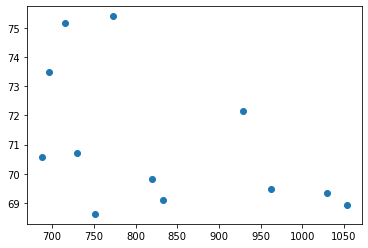

In [72]:
plt.scatter(g1w['Crime Count'],g1w['avgHumidity'])

In [73]:
sts.pearsonr(g1w['Crime Count'],g1w['avgHumidity'])

(-0.4769323515651195, 0.11693759601580216)

In [24]:
#Perform API call to get Montly weather avergages for Atlanta
base_url = 'https://api.worldweatheronline.com/premium/v1/weather.ashx'
q = 'Atlanta'
output_format = 'json'

#Parameter for the API call, units will be handled in Metric system
params = {'key':wokey, 'q':q, 'format':output_format}

response = requests.get(base_url,params=params).json()

In [25]:
pprint(response)

{'data': {'ClimateAverages': [{'month': [{'absMaxTemp': '13.287968',
                                          'absMaxTemp_F': '55.9',
                                          'absMinTemp': '-3.4',
                                          'absMinTemp_F': '25.9',
                                          'avgCloud': '42.295757',
                                          'avgDailyRainfall': '0.73',
                                          'avgDailyRainfall_inch': '0.03',
                                          'avgDryDays': '21',
                                          'avgFogDays': '6',
                                          'avgHumidity': '72.16708',
                                          'avgMaxTemp': '10.0',
                                          'avgMaxTemp_F': '50.0',
                                          'avgMinTemp': '1.9',
                                          'avgMinTemp_F': '35.4',
                                          'avgMonthlyRainfall': '22.49',

                                   'chanceofovercast': '92',
                                   'chanceofrain': '0',
                                   'chanceofremdry': '27',
                                   'chanceofsnow': '59',
                                   'chanceofsunshine': '4',
                                   'chanceofthunder': '7',
                                   'chanceofwindy': '0',
                                   'cloudcover': '100',
                                   'humidity': '90',
                                   'precipInches': '0.1',
                                   'precipMM': '3.4',
                                   'pressure': '1015',
                                   'pressureInches': '30',
                                   'tempC': '-0',
                                   'tempF': '32',
                                   'time': '0',
                                   'uvIndex': '1',
                                   'visibility': '8',
   

                                   'precipMM': '0.0',
                                   'pressure': '1020',
                                   'pressureInches': '31',
                                   'tempC': '17',
                                   'tempF': '63',
                                   'time': '1500',
                                   'uvIndex': '5',
                                   'visibility': '10',
                                   'visibilityMiles': '6',
                                   'weatherCode': '116',
                                   'weatherDesc': [{'value': 'Partly cloudy'}],
                                   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0002_sunny_intervals.png'}],
                                   'winddir16Point': 'NNW',
                                   'winddirDegree': '336',
                                   'windspeedKmph': '4',
                                   'windsp

                                   'WindGustKmph': '9',
                                   'WindGustMiles': '6',
                                   'chanceoffog': '0',
                                   'chanceoffrost': '0',
                                   'chanceofhightemp': '0',
                                   'chanceofovercast': '90',
                                   'chanceofrain': '0',
                                   'chanceofremdry': '89',
                                   'chanceofsnow': '0',
                                   'chanceofsunshine': '14',
                                   'chanceofthunder': '0',
                                   'chanceofwindy': '0',
                                   'cloudcover': '100',
                                   'humidity': '93',
                                   'precipInches': '0.0',
                                   'precipMM': '0.0',
                                   'pressure': '1008',
                              

                                   'cloudcover': '33',
                                   'humidity': '27',
                                   'precipInches': '0.0',
                                   'precipMM': '0.0',
                                   'pressure': '1034',
                                   'pressureInches': '31',
                                   'tempC': '-8',
                                   'tempF': '18',
                                   'time': '2100',
                                   'uvIndex': '1',
                                   'visibility': '10',
                                   'visibilityMiles': '6',
                                   'weatherCode': '116',
                                   'weatherDesc': [{'value': 'Partly cloudy'}],
                                   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png'}],
                                   'winddir16Point':

                                   'WindChillF': '24',
                                   'WindGustKmph': '13',
                                   'WindGustMiles': '8',
                                   'chanceoffog': '0',
                                   'chanceoffrost': '30',
                                   'chanceofhightemp': '0',
                                   'chanceofovercast': '84',
                                   'chanceofrain': '0',
                                   'chanceofremdry': '87',
                                   'chanceofsnow': '0',
                                   'chanceofsunshine': '10',
                                   'chanceofthunder': '0',
                                   'chanceofwindy': '0',
                                   'cloudcover': '100',
                                   'humidity': '98',
                                   'precipInches': '0.0',
                                   'precipMM': '0.0',
                            

                                   'chanceofwindy': '0',
                                   'cloudcover': '29',
                                   'humidity': '71',
                                   'precipInches': '0.0',
                                   'precipMM': '0.0',
                                   'pressure': '1024',
                                   'pressureInches': '31',
                                   'tempC': '8',
                                   'tempF': '46',
                                   'time': '2100',
                                   'uvIndex': '1',
                                   'visibility': '10',
                                   'visibilityMiles': '6',
                                   'weatherCode': '116',
                                   'weatherDesc': [{'value': 'Partly cloudy'}],
                                   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png'

In [102]:
#We will take the monthly average to get avgMaxTemp_F, avgPressure_inch, avgRainDays,avgHumidity,and avgWindSpeed_mph
crime['avgMaxTemp_F'] =''
crime['avgPressure_inch'] =''
crime['avgRainDays'] =''
crime['avgHumidity'] =''
crime['avgWindSpeed_mph'] =''

for month in range(0,12):
    crime['avgMaxTemp_F'].loc[crime['Month']==(month+1)]= response['data']['ClimateAverages'][0]['month'][month]['avgMaxTemp_F']
    crime['avgPressure_inch'].loc[crime['Month']==(month+1)]= response['data']['ClimateAverages'][0]['month'][month]['avgPressure_inch']
    crime['avgRainDays'].loc[crime['Month']==(month+1)]= response['data']['ClimateAverages'][0]['month'][month]['avgRainDays']
    crime['avgHumidity'].loc[crime['Month']==(month+1)]= response['data']['ClimateAverages'][0]['month'][month]['avgHumidity']
    crime['avgWindSpeed_mph'].loc[crime['Month']==(month+1)]= response['data']['ClimateAverages'][0]['month'][month]['avgWindSpeed_mph']

In [125]:
#Create Gmap of Crime in Atlanta in 2016 for a summer month for Top Crime Type

g1.loc[g1['Month']==6]

#Configure Gmaps
gmaps.configure(api_key=gkey)

#Load parameters
coordg1 = g1.loc[g1['Month']==6][['lat','long']]
coordg2 = g2.loc[g2['Month']==6][['lat','long']]

figure_layout = {
    
    'width':'1000px',
    'height':'600px',
    'border':'1px solid black',
    'padding':'1px',
    'margin':'0 auto 0 auto'
}

f = gmaps.figure(layout=figure_layout)
f.add_layer(gmaps.symbol_layer(coordg1, fill_color='red', stroke_color='red', scale=2))
f.add_layer(gmaps.symbol_layer(coordg2, fill_color='green', stroke_color='green', scale=2))
f

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [11]:
crime.groupby('Month').count()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Day,Year
Month,,,,,,,,,,,
01,2376,2376,2376,2376,2376,2273,2352,2376,2376,2376,2376
02,2034,2034,2034,2034,2034,1955,2015,2034,2034,2034,2034
03,2095,2095,2095,2095,2095,1994,2077,2095,2095,2095,2095
04,2257,2257,2257,2257,2257,2161,2242,2257,2257,2257,2257
05,2537,2537,2537,2537,2537,2445,2528,2537,2537,2537,2537
06,2431,2431,2431,2431,2431,2325,2416,2431,2431,2431,2431
07,2597,2597,2597,2597,2597,2459,2565,2597,2597,2597,2597
08,2724,2724,2724,2724,2724,2590,2696,2724,2724,2724,2724
09,2668,2668,2668,2668,2668,2536,2638,2668,2668,2668,2668


In [22]:
crime

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year,avgMaxTemp_F
0,HOMICIDE,163051391092,10/31/2016,1205 METROPOLITAN AVE SE,612,East Atlanta,W,33.74173,-84.34749,10,31,2016,
1,AUTO THEFT,163030548,10/31/2016,180 PONCE DE LEON AVE NE,505,Midtown,E,33.77285,-84.38149,10,31,2016,
2,LARCENY-FROM VEHICLE,163041611,10/31/2016,1783 JOHNSON RD NW,110,Rockdale,G,33.78547,-84.44593,10,31,2016,
3,LARCENY-FROM VEHICLE,163050183,10/31/2016,1000 NORTHSIDE DR NW,501,Home Park,E,33.78196,-84.40835,10,31,2016,
4,AUTO THEFT,163050218,10/31/2016,2264 COUNTRY CLUB DR SW,409,Southwest,R,33.69384,-84.49398,10,31,2016,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29126,BURGLARY-RESIDENCE,162391167,09/01/2016,834 LULLWATER RD NE,608,Druid Hills,N,33.77741,-84.33535,09,01,2016,
29127,LARCENY-NON VEHICLE,162420896,09/01/2016,319 MCDONOUGH BLVD SE,307,Chosewood Park,Y,33.71664,-84.37816,09,01,2016,
29128,LARCENY-FROM VEHICLE,162430003,09/01/2016,1950 CHILDRESS DR SW,407,Tuxedo Park,A,33.85844,-84.39221,09,01,2016,
29129,LARCENY-FROM VEHICLE,162450076,09/01/2016,855 PEACHTREE STREET NE,505,Midtown,E,33.77800,-84.38424,09,01,2016,


In [47]:
months =response['data']['ClimateAverages'][0]['month']

In [49]:
months[0]['avgMaxTemp_F']

'50.0'

In [20]:
params

{'appid': '4d524571c20ee817db623756271ee8b2',
 'month': '10',
 'day': '12',
 'q': 'Atlanta, Georgia'}

In [7]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29131 entries, 0 to 29130
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   crime         29131 non-null  object 
 1   number        29131 non-null  int64  
 2   date          29131 non-null  object 
 3   location      29131 non-null  object 
 4   beat          29131 non-null  object 
 5   neighborhood  27795 non-null  object 
 6   npu           28877 non-null  object 
 7   lat           29131 non-null  float64
 8   long          29131 non-null  float64
 9   Month         29131 non-null  object 
 10  Day           29131 non-null  object 
 11  Year          29131 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 2.7+ MB


In [12]:
crime['Month'].value_counts()

08    2724
09    2668
10    2664
07    2597
05    2537
12    2529
06    2431
01    2376
04    2257
11    2219
03    2095
02    2034
Name: Month, dtype: int64

In [14]:
crime.groupby(by='Month').count()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Day,Year
Month,,,,,,,,,,,
01,2376,2376,2376,2376,2376,2273,2352,2376,2376,2376,2376
02,2034,2034,2034,2034,2034,1955,2015,2034,2034,2034,2034
03,2095,2095,2095,2095,2095,1994,2077,2095,2095,2095,2095
04,2257,2257,2257,2257,2257,2161,2242,2257,2257,2257,2257
05,2537,2537,2537,2537,2537,2445,2528,2537,2537,2537,2537
06,2431,2431,2431,2431,2431,2325,2416,2431,2431,2431,2431
07,2597,2597,2597,2597,2597,2459,2565,2597,2597,2597,2597
08,2724,2724,2724,2724,2724,2590,2696,2724,2724,2724,2724
09,2668,2668,2668,2668,2668,2536,2638,2668,2668,2668,2668
